# Plot all data present in a JSON file on a map.
- original address
- facilities
- isochrones
- population data

# Dependencies

In [24]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt 

# Load JSON files

In [4]:
def load_data(path):
    try: 
        with open(path, 'r') as file:
            data = json.load(file)
        return data
    except Exception as e:
        print(f"An error as occured: {e}")
 
def get_file_names(directory):
    return [
        os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.json')
    ]

In [5]:
directory = r"../data/google_data_isochrone_pop_cgpt"
FILES = get_file_names(directory)
FILES

['../data/google_data_isochrone_pop_cgpt\\Ex1_8004_Zurich_Werdgartengasse_4.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex2_3027_Bern_Colombstrasse_39.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex3_1006_Lausanne_Av_d_Ouchy_58.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex4_8355_Aadorf_Bruggwiesenstrasse_5.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex5_6319_Allenwinden_Winzruti_39.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex6_8005_Zurich_Heinrichstrasse_200.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex7_8003_Zurich_Birmensdorferstrasse_108.json']

In [8]:
# get Constructor Academy:
CONSAC = load_data(FILES[5]) 
CONSAC['original_address']

{'address': '8005 Zürich, Heinrichstrasse 200',
 'coordinates': [47.3877722, 8.5254298]}

# Get neighborhood description into dataframe

In [7]:
CONSAC['facilities'].keys()
CONSAC['facilities']['bars']['count']
CONSAC['population']['total_pop']


16421

In [9]:
def get_neighborhood_data(data):
    total_pop = data['population']['total_pop']
    
    neighborhood_data = []
    for facility_type in data['facilities'].keys():
        neighborhood_data.append({
            'facility_type': facility_type,
            'count_raw': data['facilities'][facility_type]['count'],
            'count_per_10\'000_inhabitants':  round( data['facilities'][facility_type]['count'] / total_pop * 10000 , 1)
            })
    df = pd.DataFrame(neighborhood_data)
    return df

In [10]:
get_neighborhood_data(CONSAC)

,facility_type,count_raw,count_per_10'000_inhabitants
0,bars,13,7.9
1,restaurants,15,9.1
2,kindergarten,16,9.7
3,public_transportation,37,22.5
4,gym_fitness,16,9.7
5,grocery_stores_supermarkets,21,12.8
6,gas_ev_charging,12,7.3
7,schools,4,2.4


# Get facility data into dataframe

In [11]:
def get_facility_data(data):
    facility_data = []
    for facility_type in data['facilities'].keys():
        for facility_i in data['facilities'][facility_type]['data']:
            facility_data.append({
                'facility_type': facility_type,
                'name': facility_i['name'],
                'lat': facility_i['location']['lat'],
                'lon': facility_i['location']['lng'],
                'address': facility_i['vicinity'],
                'rating': facility_i['rating'],
                'num_ratings': facility_i['num_ratings'],
                'url': facility_i['url'],
                'travel_time': facility_i['travel_time']
            })
    df = pd.DataFrame(facility_data)
    return df

In [12]:
df = get_facility_data(CONSAC)
df.head(3)

,facility_type,name,lat,lon,address,rating,num_ratings,url,travel_time
0,bars,CLOUDS,47.386006,8.517157,"Maagplatz 5, Zürich",4,1954,https://maps.google.com/?cid=10852654815929467025,10 mins
1,bars,LaSalle,47.388702,8.518930,"Schiffbaustrasse 4, Zürich",4.3,593,https://maps.google.com/?cid=11155055571961580071,8 mins
2,bars,Markthalle,47.387590,8.526072,"Limmatstrasse 231, Zürich",4.3,2069,https://maps.google.com/?cid=4515352646433561693,5 mins


# Get population data into dataframe

In [13]:
CONSAC['population'].keys()
CONSAC['population']['STATPOP_squares'][:5]
pd.DataFrame(CONSAC['population']['STATPOP_squares']).head(3)

,B22BTOT,E_wgs84,N_wgs84
0,123,47.386357,8.516017
1,290,47.387256,8.516035
2,3,47.389055,8.516071


In [14]:
def get_population_data(data):
    """ Data is JSON file"""
    df = pd.DataFrame(data['population']['STATPOP_squares'])
    return df

# Get isochrone data into dataframe

In [15]:
print(len(CONSAC['isochrone']['features']))
CONSAC['isochrone']['features'][0]['properties']['value'] # travel time
CONSAC['isochrone']['features'][0]['geometry']['coordinates'][0][:3] # coordinates ("[0]" in the second last position is necessary since there are two [] in excess!)

6


[[8.522537, 47.386666], [8.52267, 47.386331], [8.524888, 47.385637]]

In [16]:
def get_isochrone_data(data):
    isochrone_data = []
    for isochrone in range(len(data['isochrone']['features'])):
        for coord in range(len(data['isochrone']['features'][isochrone]['geometry']['coordinates'][0])): #("[0]" at the end is necessary since there are two [] in excess!)
            isochrone_data.append({
                'travel_time': data['isochrone']['features'][isochrone]['properties']['value'],
                'lat': data['isochrone']['features'][isochrone]['geometry']['coordinates'][0][coord][1],
                'lon': data['isochrone']['features'][isochrone]['geometry']['coordinates'][0][coord][0],
            })
    df = pd.DataFrame(isochrone_data)
    return df

get_isochrone_data(CONSAC).head(3)

,travel_time,lat,lon
0,180.0,47.386666,8.522537
1,180.0,47.386331,8.522670
2,180.0,47.385637,8.524888


# Create empty base map

In [17]:
def create_base_map(FILE, width=800, height=600, zoom=13):

    # coords of original address:
    LAT = FILE['original_address']['coordinates'][0]
    LON = FILE['original_address']['coordinates'][1]

    # create base map with original adress.
    base_map = go.Figure(go.Scattermapbox())
    
    # Set up the layout for the base map
    base_map.update_layout(
        mapbox_style="open-street-map",
        mapbox_zoom=zoom, 
        mapbox_center={"lat": LAT, "lon": LON},
        width=width,
        height=height,
        margin=dict(r=0, t=0, l=0, b=0), 
        showlegend=False
    )
    return base_map

# Create layer "Original address"

In [18]:
def add_original_address(base_map, FILE):

    # coords of original address:
    LAT = FILE['original_address']['coordinates'][0]
    LON = FILE['original_address']['coordinates'][1]

    # create base map with original adress.
    address_layer = go.Scattermapbox(
        lat=pd.Series(LAT),  
        lon=pd.Series(LON),  
        mode='markers', 
        marker=dict(size=20, color='black', opacity= 1), 
        text = FILE['original_address']['address'],
        hoverinfo='text',
        showlegend=False
    )
    # add the layer on the base map
    base_map.add_trace(address_layer)
    base_map.update_layout( margin=dict(r=0, t=0, l=0, b=0), showlegend=False)

    return base_map

In [19]:
# Color Mapping to plot the elements separately:
# adapted for the new files
color_mapping = {'schools': 'blue',
 'grocery_stores_supermarkets': 'red',
 'public_transportation': 'purple',
 'restaurants': 'yellow',
 'bars': 'pink',
 'kindergarten':'orange',
 'gym_fitness': 'brown',
 'gas_ev_charging':'cyan'
 }

# Create layer "Places"

In [20]:
def add_places(base_map, FILE):
    # format data
    neighborhood = get_facility_data(FILE)
    # define the text to be dislayed:
    neighborhood['hover_text'] = neighborhood.apply(lambda row: f"<b>{row['name']}</b><br><i>{row['facility_type']}</i><br>{row['address']} <br><br>Rating: {row['rating']}<br>Nb ratings: {row['num_ratings']}<br><br><i>Walking time: {row['travel_time']}</i> <br><br>", axis=1)
    # define different colors for each of the facility type
    unique_facilities = neighborhood['facility_type'].unique()
    neighborhood['marker_color'] = neighborhood['facility_type'].map(color_mapping)

    # create the layer:
    places_layer = go.Scattermapbox(
    lat=neighborhood['lat'],  
    lon=neighborhood['lon'],  
    mode='markers', 
    marker=dict(size=10,  color=neighborhood['marker_color'], opacity= 1), 
    text= neighborhood['hover_text'],
    hoverinfo='text',
    hovertemplate='%{text}<extra></extra>'  ,
    showlegend=False 
    )
    # add the layer on the base map
    base_map.add_trace(places_layer)
    base_map.update_layout( margin=dict(r=0, t=0, l=0, b=0), showlegend=False)
    
    return base_map

# Create layer "Population"

In [21]:
def add_population(base_map, FILE):
    # format data
    df = get_population_data(FILE)
    # create the layer:
    pop_layer = go.Scattermapbox(
    lat=df['E_wgs84'],  
    lon=df['N_wgs84'],  
    mode='markers', 
    marker=dict(size=40,  color='purple', opacity=0.5), 
    text= df['B22BTOT'],
    hoverinfo='text',
    hovertemplate='%{text}<extra></extra>'  ,
    showlegend=False 
    )
    # add the layer on the base map
    base_map.add_trace(pop_layer)
    base_map.update_layout( margin=dict(r=0, t=0, l=0, b=0), showlegend=False)
    
    return base_map

# Create layer "Isochrone" - currently set to display only the 10min walking distance

In [28]:
def add_isochrone(base_map, FILE):
    # format data
    df = get_isochrone_data(FILE)

    for travel_time in df['travel_time'].unique():
        df_filtered = df[df['travel_time']==travel_time] 
        # create the layer:
        new_layer = go.Scattermapbox(
            lat=df_filtered['lat'],  
            lon=df_filtered['lon'],  
            mode='lines', # no markers
            line=dict(width=1, color='rgba(10,80,50,1)'), 
            fill='toself', 
            fillcolor='rgba(10,80,50,0.25)',  
            showlegend = False,
            marker=dict(size=1, color='blue'),
            text= str(travel_time/60) + 'min. walking',
            hoverinfo='text'
            )
        base_map.add_trace(new_layer)
        
    base_map.update_layout( margin=dict(r=0, t=0, l=0, b=0), showlegend=False)

    return base_map

# Create layer "barplots"

In [23]:
def add_barplots(base_map, FILE):
    df = get_neighborhood_data(FILE)

    barplot_layer = go.Bar(
        x = df['facility_type'],
        y = df['count_raw']
    )

    base_map.add_trace(barplot_layer)
    
    base_map.update_layout(
        xaxis=dict( domain=[0.7, 1]  # Adjust position of the bar plot on the map
                    ),
        yaxis2=dict( domain=[0.7, 1]  # Adjust position of the bar plot on the map
                    ),
        yaxis=dict( domain=[0, 0.6] ), # This keeps the map on the lower part of the plot
        margin=dict(r=0, t=0, l=0, b=0), 
        showlegend=False
        )

    return base_map


### next idea: try to add the barplots of the facility counts to the map
Code below is from Seckin

In [25]:
TIME_BOUND = 10 # minutes

def plot_neighborhood(FILE):

    df = get_neighborhood_data(FILE)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    count_sorted = df.sort_values('count_raw', ascending=False)
    sns.barplot(data=count_sorted,
                x='count_raw', y=count_sorted['facility_type'],
                ax=axes[0])
    axes[0].set_title('Facility Count')
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel('Facility')

    density_sorted = df.sort_values('count_per_10\'000_inhabitants', ascending=False)
    sns.barplot(data=density_sorted,
                x='count_per_10\'000_inhabitants', y=density_sorted['facility_type'],
                ax=axes[1])
    axes[1].set_title('Density of facilities (per 10\'000 inhabitants)')
    axes[1].set_xlabel('Densty')
    axes[1].set_ylabel('')
    
    original_address = FILE['original_address']['address']
    plt.suptitle(f"Facilities within a {TIME_BOUND}-minute walk from {original_address}")
    
    plt.tight_layout()
    plt.show()

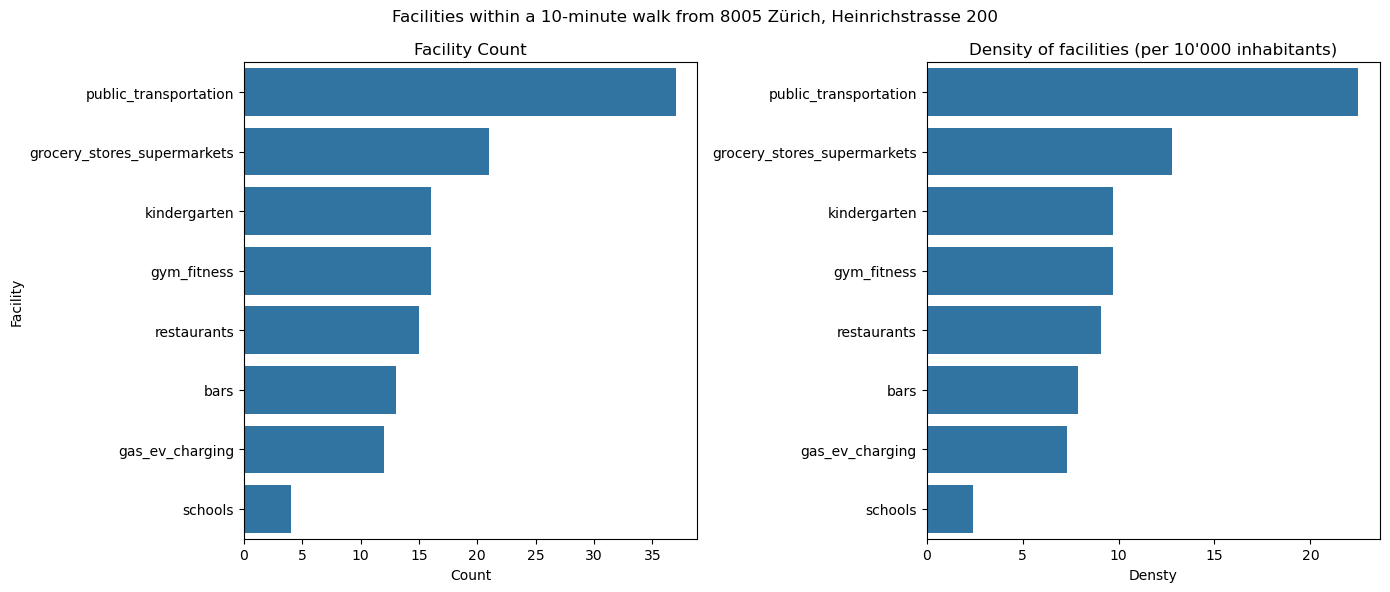

In [26]:
plot_neighborhood(CONSAC)

# Plot maps

In [29]:
FILE = load_data(FILES[5])
base_map = create_base_map(FILE, 800, 800, 14)
add_population(base_map, FILE)
add_isochrone(base_map, FILE)
add_places(base_map, FILE)
add_original_address(base_map, FILE)
add_barplots(base_map, FILE)

### as we can see, the barplots appears BELOW the map !!! no way found make it appear on top !

In [30]:
FILE = load_data(FILES[0])
base_map = create_base_map(FILE, 800, 800, 14)
add_population(base_map, FILE)
add_isochrone(base_map, FILE)
add_places(base_map, FILE)
add_original_address(base_map, FILE)

In [33]:
FILE = load_data(FILES[1])
base_map = create_base_map(FILE, 800, 800, 14)
add_population(base_map, FILE)
add_isochrone(base_map, FILE)
add_places(base_map, FILE)
add_original_address(base_map, FILE)

In [34]:
FILE = load_data(FILES[2])
base_map = create_base_map(FILE, 800, 800, 14)
add_population(base_map, FILE)
add_isochrone(base_map, FILE)
add_places(base_map, FILE)
add_original_address(base_map, FILE)

In [32]:
FILE = load_data(FILES[3])
base_map = create_base_map(FILE, 800, 800, 14)
add_population(base_map, FILE)
add_isochrone(base_map, FILE)
add_places(base_map, FILE)
add_original_address(base_map, FILE)

In [35]:
FILE = load_data(FILES[4])
base_map = create_base_map(FILE, 800, 800, 14)
add_population(base_map, FILE)
add_isochrone(base_map, FILE)
add_places(base_map, FILE)
add_original_address(base_map, FILE)

In [36]:
FILE = load_data(FILES[6])
base_map = create_base_map(FILE, 800, 800, 14)
add_population(base_map, FILE)
add_isochrone(base_map, FILE)
add_places(base_map, FILE)
add_original_address(base_map, FILE)

# END OF NOTEBOOK